# Probe Concepts

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/probe-concepts.ipynb)

## Setup

In [1]:
MODE = "local"  # "colab" | "colab-dev" | "local"

In [2]:
if MODE == "colab":
    !pip install -q lczerolens[hf]
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    !pip install -q ./lczerolens --extra hf

## Load a Model

Load a leela network from hf:

In [3]:
from lczerolens import LczeroModel

maia_1100 = LczeroModel.from_hf("lczerolens/maia-1100")
maia_1900 = LczeroModel.from_hf("lczerolens/maia-1900")

## Import a Game Dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("lczerolens/tcec-boards", split="train", streaming=True)
dataset

IterableDataset({
    features: ['gameid', 'moves', 'fen', 'label'],
    num_shards: 2
})

In [5]:
from datasets import Dataset

work_ds = dataset.shuffle(seed=42).take(1_000)
work_ds = Dataset.from_generator(lambda: (yield from work_ds), features=work_ds.features)
work_ds = work_ds.train_test_split(test_size=0.2)

train_ds = work_ds["train"]
test_ds = work_ds["test"]

work_ds

DatasetDict({
    train: Dataset({
        features: ['gameid', 'moves', 'fen', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['gameid', 'moves', 'fen', 'label'],
        num_rows: 200
    })
})

## Create a Concept

In [6]:
from lczerolens.concepts import HasThreat
from lczerolens.data import BoardData

concept = HasThreat(piece="N", relative=True)

train_boards, train_labels = BoardData.concept_collate_fn(list(train_ds), concept)
test_boards, test_labels = BoardData.concept_collate_fn(list(test_ds), concept)

print(f"Positive examples (train): {sum(train_labels)}")
print(f"Positive examples (test): {sum(test_labels)}")

Positive examples (train): 97
Positive examples (test): 27


## Train Linear Probes


In [7]:
import torch
from tensordict import TensorDict

from tdhook.latent.probing import Probing, SklearnProbeManager
from sklearn.linear_model import LogisticRegression

probe_manager = SklearnProbeManager(LogisticRegression, {"max_iter": 1000}, lambda x, y: concept.compute_metrics(x, y))

with Probing("block\d/conv2/relu", probe_manager.probe_factory, additional_keys=["labels", "step_type"]).prepare(
    maia_1100
) as hooked_module:
    with torch.no_grad():
        train_inputs = TensorDict(
            {
                "board": maia_1100.prepare_boards(*train_boards),
                "labels": torch.tensor(train_labels),
                "step_type": "fit",
            },
            batch_size=len(train_boards),
        )
        hooked_module(train_inputs)

        test_inputs = TensorDict(
            {
                "board": maia_1100.prepare_boards(*test_boards),
                "labels": torch.tensor(test_labels),
                "step_type": "predict",
            },
            batch_size=len(test_boards),
        )
        hooked_module(test_inputs)
        maia_1100_metrics = probe_manager.predict_metrics

probe_manager.reset_probes()
probe_manager.reset_metrics()

with Probing("block\d/conv2/relu", probe_manager.probe_factory, additional_keys=["labels", "step_type"]).prepare(
    maia_1900
) as hooked_module:
    with torch.no_grad():
        train_inputs = TensorDict(
            {
                "board": maia_1900.prepare_boards(*train_boards),
                "labels": torch.tensor(train_labels),
                "step_type": "fit",
            },
            batch_size=len(train_boards),
        )
        hooked_module(train_inputs)

        test_inputs = TensorDict(
            {
                "board": maia_1900.prepare_boards(*test_boards),
                "labels": torch.tensor(test_labels),
                "step_type": "predict",
            },
            batch_size=len(test_boards),
        )
        hooked_module(test_inputs)
        maia_1900_metrics = probe_manager.predict_metrics

## Render the Results

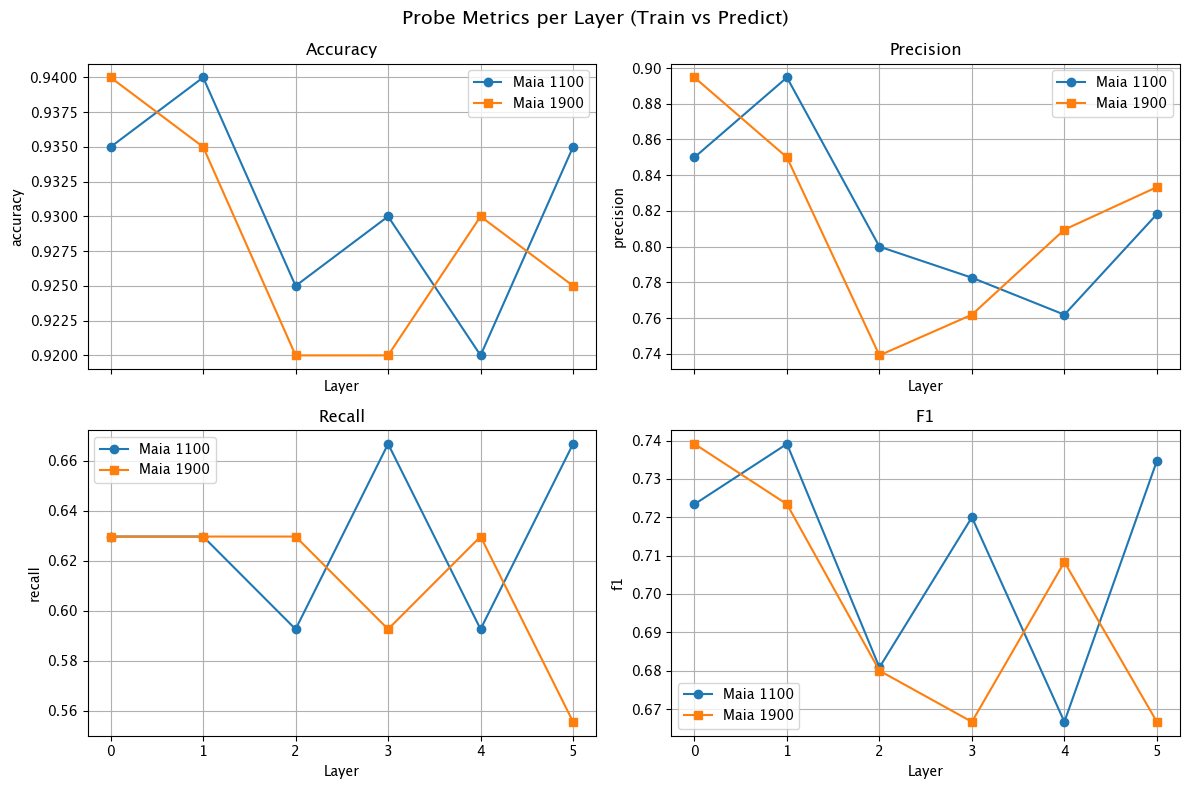

In [8]:
import re
import matplotlib.pyplot as plt


# --------------------------------------------------
def get_layer_number(key: str) -> int:
    return int(re.search(r"block(\d+)/conv2/relu", key).group(1))


def collect(metrics_dict):
    """Return {metric_name: {"layers": [...], "values": [...]}}."""
    out = {}
    for k, v in metrics_dict.items():  # k = layer-key, v = {metric: value}
        layer = get_layer_number(k)
        for name, val in v.items():
            out.setdefault(name, {"layers": [], "values": []})
            out[name]["layers"].append(layer)
            out[name]["values"].append(val)
    # sort every metric by layer
    for d in out.values():
        layers, vals = zip(*sorted(zip(d["layers"], d["values"])))
        d["layers"], d["values"] = layers, vals
    return out


metrics_1100 = collect(maia_1100_metrics)
metrics_1900 = collect(maia_1900_metrics)


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

for ax, metric in zip(axes, metrics_1100):
    ax.plot(metrics_1100[metric]["layers"], metrics_1100[metric]["values"], marker="o", label="Maia 1100")
    ax.plot(metrics_1900[metric]["layers"], metrics_1900[metric]["values"], marker="s", label="Maia 1900")
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Layer")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

for ax in axes[len(metrics_1100) :]:
    ax.axis("off")

fig.suptitle("Probe Metrics per Layer (Train vs Predict)", fontsize=14)
plt.tight_layout()
plt.show()